In [2]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
#import xgboost as xgb
h2o.init(max_mem_size='6G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,08 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,"21 days, 19 hours and 18 minutes"
H2O cluster name:,H2O_from_python_zhaorc_9ea5bz
H2O cluster total nodes:,1
H2O cluster free memory:,4.445 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


### Import Data & Create Sales Price Dummy Column in Test Dataset

In [3]:
trainori = h2o.import_file('train.csv')
testori = h2o.import_file('test.csv')
dummy_col = np.random.rand(testori.shape[0])
testori = testori.cbind(h2o.H2OFrame(dummy_col))
cols = testori.columns
cols[-1] = 'SalePrice'
testori.columns = cols
print(trainori.shape)
print(testori.shape)

(1460, 81)
(1459, 81)


In [5]:
excludevars = ['ID','SalePrice']
def get_type_lists(frame, rejects=excludevars):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [6]:
original_nums, cats = get_type_lists(trainori)

Numeric = ['BsmtUnfSF', 'BsmtFinSF2', 'OpenPorchSF', 'BsmtFullBath', 'MSSubClass', 'TotalBsmtSF', 'YearRemodAdd', 'ScreenPorch', 'BsmtFinSF1', 'LowQualFinSF', 'YrSold', 'GarageCars', 'LotArea', 'MiscVal', 'MasVnrArea', 'GarageYrBlt', 'FullBath', 'LotFrontage', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'BedroomAbvGr', '3SsnPorch', 'PoolArea', 'EnclosedPorch', 'KitchenAbvGr', 'YearBuilt', 'OverallQual', 'WoodDeckSF', 'GrLivArea', 'BsmtHalfBath', '2ndFlrSF', 'HalfBath', 'Id', 'Fireplaces', 'MoSold', 'OverallCond']

Categorical = ['Electrical', 'LotConfig', 'Condition1', 'LotShape', 'SaleCondition', 'Functional', 'GarageType', 'Utilities', 'Condition2', 'Fence', 'SaleType', 'ExterCond', 'MiscFeature', 'MSZoning', 'KitchenQual', 'Exterior1st', 'BldgType', 'RoofMatl', 'HouseStyle', 'PavedDrive', 'LandContour', 'HeatingQC', 'BsmtFinType1', 'RoofStyle', 'ExterQual', 'MasVnrType', 'BsmtFinType2', 'PoolQC', 'Foundation', 'FireplaceQu', 'BsmtExposure', 'LandSlope', 'CentralAir', 'Alley', 'BsmtCon

## Split into train and validation (before doing prep)

In [83]:
#train, valid = trainori.split_frame([0.7], seed=12345)
#print(train.shape)
#print(valid.shape)

(1001, 81)
(459, 81)


In [7]:
# do this first
train = trainori
test = testori
print(train.shape)

(1460, 81)


## Preprocessing

In [8]:
pandas_train = train.as_data_frame(use_pandas=True) #Convert to Pandas frame
pandas_test = test.as_data_frame(use_pandas=True) 


In [9]:
# Lotfrontage
temp = pandas_train.groupby('Neighborhood', as_index=False)['LotFrontage'].median()
temp = temp.rename(columns={"LotFrontage":"LotFrontage2"})
pandas_train = pd.merge(pandas_train, temp, how='left', on='Neighborhood')
pandas_train['LotFrontage'][pandas_train['LotFrontage'].isnull()] = pandas_train['LotFrontage2'][pandas_train['LotFrontage'].isnull()]
pandas_train = pandas_train.drop('LotFrontage2', axis=1)


temp = pandas_test.groupby('Neighborhood', as_index=False)['LotFrontage'].median()
temp = temp.rename(columns={"LotFrontage":"LotFrontage2"})
pandas_test = pd.merge(pandas_test, temp, how='left', on='Neighborhood')
pandas_test['LotFrontage'][pandas_test['LotFrontage'].isnull()] = pandas_test['LotFrontage2'][pandas_test['LotFrontage'].isnull()]
pandas_test = pandas_test.drop('LotFrontage2', axis=1)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# Alley
pandas_train["Alley"].fillna("None", inplace=True)

pandas_test["Alley"].fillna("None", inplace=True)


In [11]:
# MasVnrType, MasVnrArea
pandas_train['MasVnrType'].fillna(pandas_train['MasVnrType'].value_counts().index[0],inplace=True)
pandas_train['MasVnrArea'].fillna(pandas_train['MasVnrArea'].mode()[0],inplace=True)


pandas_test['MasVnrType'].fillna(pandas_train['MasVnrType'].value_counts().index[0],inplace=True)
pandas_test['MasVnrArea'].fillna(pandas_train['MasVnrArea'].mode()[0],inplace=True)

In [12]:
# Basement related

basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

pandas_train["BsmtQual"].fillna("None", inplace=True)
pandas_train["BsmtCond"].fillna("None", inplace=True)
pandas_train["BsmtExposure"].fillna("None", inplace=True)
pandas_train["BsmtFinType1"].fillna("None", inplace=True)
pandas_train["BsmtFinSF1"].fillna(0, inplace=True)
pandas_train["BsmtFinType2"].fillna("None", inplace=True)
pandas_train["BsmtFinSF2"].fillna(0, inplace=True)
pandas_train["BsmtUnfSF"].fillna(0, inplace=True)

pandas_test["BsmtQual"].fillna("None", inplace=True)
pandas_test["BsmtCond"].fillna("None", inplace=True)
pandas_test["BsmtExposure"].fillna("None", inplace=True)
pandas_test["BsmtFinType1"].fillna("None", inplace=True)
pandas_test["BsmtFinSF1"].fillna(0, inplace=True)
pandas_test["BsmtFinType2"].fillna("None", inplace=True)
pandas_test["BsmtFinSF2"].fillna(0, inplace=True)
pandas_test["BsmtUnfSF"].fillna(0, inplace=True)

In [13]:
pandas_test[basement_cols][pandas_train['BsmtQual'].isnull()==True]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2


In [14]:
# Electrical
pandas_train["Electrical"].fillna("SBrkr", inplace=True)

pandas_test["Electrical"].fillna("SBrkr", inplace=True)

In [15]:
# FireplaceQu
pandas_train["FireplaceQu"].fillna("None", inplace=True)

pandas_test["FireplaceQu"].fillna("None", inplace=True)

In [16]:
# Garage related
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']

pandas_train["GarageType"].fillna("None", inplace=True)
pandas_train["GarageQual"].fillna("None", inplace=True)
pandas_train["GarageCond"].fillna("None", inplace=True)
pandas_train["GarageFinish"].fillna("None", inplace=True)
pandas_train["GarageCars"].fillna(0, inplace=True)
pandas_train["GarageArea"].fillna(0, inplace=True)

pandas_test["GarageType"].fillna("None", inplace=True)
pandas_test["GarageQual"].fillna("None", inplace=True)
pandas_test["GarageCond"].fillna("None", inplace=True)
pandas_test["GarageFinish"].fillna("None", inplace=True)
pandas_test["GarageCars"].fillna(0, inplace=True)
pandas_test["GarageArea"].fillna(0, inplace=True)

In [17]:
# GarageYrBlt Binning

minval = pandas_train['GarageYrBlt'].min()
maxval = pandas_train['GarageYrBlt'].max()+1
binlist=[0,minval,1920,1940,1960,1980,2000,maxval]
pandas_train['GarageYrBlt'].fillna(0,inplace=True)
pandas_train['GarageYrBltBins'] = pd.cut(pandas_train['GarageYrBlt'],binlist,include_lowest=True,right=False)

minval = pandas_test['GarageYrBlt'].min()
maxval = pandas_test['GarageYrBlt'].max()+1
binlist=[0,minval,1920,1940,1960,1980,2000,maxval]
pandas_test['GarageYrBlt'].fillna(0,inplace=True)
pandas_test['GarageYrBltBins'] = pd.cut(pandas_test['GarageYrBlt'],binlist,include_lowest=True,right=False)

In [18]:
# PoolQC
pandas_train["PoolQC"].fillna("None", inplace=True)

pandas_test["PoolQC"].fillna("None", inplace=True)

In [19]:
# Fence, MiscFeature

pandas_train["Fence"].fillna("None", inplace=True)
pandas_train["MiscFeature"].fillna("None", inplace=True)

pandas_test["Fence"].fillna("None", inplace=True)
pandas_test["MiscFeature"].fillna("None", inplace=True)

In [20]:
def show_missing(pandas_frame):
    missing = pandas_frame.columns[pandas_frame.isnull().any()].tolist()
    return missing

In [21]:
show_missing(pandas_train)

[]

In [22]:
show_missing(pandas_test) # 나중에 처리해야..

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'SaleType']

In [23]:
train_h2o = h2o.H2OFrame(pandas_train) #Convert back to H2O frame 
test_h2o = h2o.H2OFrame(pandas_test)

### Set categorical vars

In [24]:
train_h2o['MSSubClass'] = train_h2o['MSSubClass'].asfactor()
train_h2o['OverallQual'] = train_h2o['OverallQual'].asfactor()
train_h2o['OverallCond'] = train_h2o['OverallCond'].asfactor()
train_h2o['YearBuilt'] = train_h2o['YearBuilt'].asfactor()
train_h2o['YearRemodAdd'] = train_h2o['YearRemodAdd'].asfactor()
#train_h2o['GarageYrBlt'] = train_h2o['GarageYrBlt'].asfactor()
train_h2o['MoSold'] = train_h2o['MoSold'].asfactor()
train_h2o['YrSold'] = train_h2o['YrSold'].asfactor()

test_h2o['MSSubClass'] = test_h2o['MSSubClass'].asfactor()
test_h2o['OverallQual'] = test_h2o['OverallQual'].asfactor()
test_h2o['OverallCond'] = test_h2o['OverallCond'].asfactor()
test_h2o['YearBuilt'] = test_h2o['YearBuilt'].asfactor()
test_h2o['YearRemodAdd'] = test_h2o['YearRemodAdd'].asfactor()
#test_h2o['GarageYrBlt'] = test_h2o['GarageYrBlt'].asfactor()
test_h2o['MoSold'] = test_h2o['MoSold'].asfactor()
test_h2o['YrSold'] = test_h2o['YrSold'].asfactor()

In [25]:
excludevars = ['Id','SalePrice', 'GarageYrBltBins2','GarageYrBlt']
nums_afterpp, cats_afterpp = get_type_lists(train_h2o, excludevars)

Numeric = ['BsmtUnfSF', 'BsmtFinSF2', 'OpenPorchSF', 'BsmtFullBath', 'TotalBsmtSF', 'ScreenPorch', 'BsmtFinSF1', 'LowQualFinSF', 'GarageCars', 'LotArea', 'MiscVal', 'MasVnrArea', 'FullBath', 'LotFrontage', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'BedroomAbvGr', '3SsnPorch', 'PoolArea', 'EnclosedPorch', 'KitchenAbvGr', 'WoodDeckSF', 'GrLivArea', 'BsmtHalfBath', '2ndFlrSF', 'HalfBath', 'Fireplaces']

Categorical = ['Electrical', 'LotConfig', 'Condition1', 'LotShape', 'MSSubClass', 'YearRemodAdd', 'SaleCondition', 'Functional', 'GarageType', 'Utilities', 'Condition2', 'Fence', 'SaleType', 'ExterCond', 'YrSold', 'MiscFeature', 'MSZoning', 'KitchenQual', 'Exterior1st', 'BldgType', 'RoofMatl', 'HouseStyle', 'PavedDrive', 'LandContour', 'HeatingQC', 'BsmtFinType1', 'RoofStyle', 'ExterQual', 'YearBuilt', 'OverallQual', 'MasVnrType', 'BsmtFinType2', 'PoolQC', 'Foundation', 'FireplaceQu', 'BsmtExposure', 'LandSlope', 'CentralAir', 'Alley', 'GarageYrBltBins', 'BsmtCond', 'BsmtQual', 'Neighborho

In [26]:
train, valid = train_h2o.split_frame([0.7], seed=12345)
test = test_h2o
print(train.shape)
print(valid.shape)

(1001, 82)
(459, 82)


In [27]:
train.describe()

Rows:1001
Cols:82




,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBltBins
type,int,enum,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,int,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,enum,enum,enum,enum,int,enum
mins,1.0,,,21.0,1300.0,,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,480.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,,3.0,,0.0,,,0.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,,,,,34900.0,
mean,724.8291708291705,,,70.74475524475535,10628.262737262736,,,,,,,,,,,,,,,,,,,,,,106.16383616383624,,,,,,,,445.5994005994004,,41.64935064935064,575.9900099900102,1063.2387612387604,,,,,1172.088911088912,341.78721278721247,5.9250749250749255,1519.8011988011988,0.4265734265734266,0.05994005994005996,1.5744255744255726,0.381618381618382,2.8711288711288696,1.0469530469530457,,6.512487512487514,,0.6203796203796214,,,1883.850149850151,,1.7932067932067925,477.4685314685315,,,,91.07392607392609,44.92407592407593,21.257742257742255,3.4565434565434567,14.763236763236765,3.376623376623376,,,,39.684315684315685,,,,,182171.95904095893,
maxs,1460.0,,,313.0,164660.0,,,,,,,,,,,,,,,,,,,,,,1378.0,,,,,,,,5644.0,,1127.0,2153.0,6110.0,,,,,4692.0,2065.0,528.0,5642.0,3.0,2.0,3.0,2.0,8.0,3.0,,14.0,,3.0,,,2010.0,,4.0,1418.0,,,,736.0,523.0,552.0,508.0,440.0,738.0,,,,15500.0,,,,,755000.0,
sigma,421.4954943866087,,,23.15278676455676,9442.37310711137,,,,,,,,,,,,,,,,,,,,,,179.66239765423683,,,,,,,,467.17326588712297,,148.91838678308972,444.45750741786287,450.4683539784607,,,,,392.4739572085174,432.9085950594231,49.51948485817861,520.2774292995629,0.5204355357324734,0.2457714312193271,0.5538098001166959,0.5002217290580031,0.8052177496650357,0.22537348289718281,,1.587480364002624,,0.6416730131026673,,,423.68187301615546,,0.7349787794173421,209.92257920181268,,,,120.05044160464608,63.01874506660877,61.04442237008644,29.83605804459362,54.16981527671003,43.98791894358055,,,,516.2493547150991,,,,,80367.94618029826,
zeros,0,,,0,0,,,,,,,,,,,,,,,,,,,,,,577,,,,,,,,326,,894,78,25,,,,,0,572,984,0,586,943,6,626,4,1,,0,,466,,,48,,48,48,,,,523,460,867,985,921,995,,,,969,,,,,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,60,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,208500.0,"[2000, 2011)"
1,2.0,20,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298

In [28]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


In [29]:
total = len(cats_afterpp)
for i, var in enumerate(cats_afterpp):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Electrical (1/51) ...
Encoding: LotConfig (2/51) ...
Encoding: Condition1 (3/51) ...
Encoding: LotShape (4/51) ...
Encoding: MSSubClass (5/51) ...
Encoding: YearRemodAdd (6/51) ...
Encoding: SaleCondition (7/51) ...
Encoding: Functional (8/51) ...
Encoding: GarageType (9/51) ...
Encoding: Utilities (10/51) ...
Encoding: Condition2 (11/51) ...
Encoding: Fence (12/51) ...
Encoding: SaleType (13/51) ...
Encoding: ExterCond (14/51) ...
Encoding: YrSold (15/51) ...
Encoding: MiscFeature (16/51) ...
Encoding: MSZoning (17/51) ...
Encoding: KitchenQual (18/51) ...
Encoding: Exterior1st (19/51) ...
Encoding: BldgType (20/51) ...
Encoding: RoofMatl (21/51) ...
Encoding: HouseStyle (22/51) ...
Encoding: PavedDrive (23/51) ...
Encoding: LandContour (24/51) ...
Encoding: HeatingQC (25/51) ...
Encoding: BsmtFinType1 (26/51) ...
Encoding: RoofStyle (27/51) ...
Encoding: ExterQual (28/51) ...
Encoding: YearBuilt (29/51) ...
Encoding: OverallQual (30/51) ...
Encoding: MasVnrType (31/51) ...


In [30]:
train.describe()

Rows:1001
Cols:133




,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBltBins,Electrical_Tencode,LotConfig_Tencode,Condition1_Tencode,LotShape_Tencode,MSSubClass_Tencode,YearRemodAdd_Tencode,SaleCondition_Tencode,Functional_Tencode,GarageType_Tencode,Utilities_Tencode,Condition2_Tencode,Fence_Tencode,SaleType_Tencode,ExterCond_Tencode,YrSold_Tencode,MiscFeature_Tencode,MSZoning_Tencode,KitchenQual_Tencode,Exterior1st_Tencode,BldgType_Tencode,RoofMatl_Tencode,HouseStyle_Tencode,PavedDrive_Tencode,LandContour_Tencode,HeatingQC_Tencode,BsmtFinType1_Tencode,RoofStyle_Tencode,ExterQual_Tencode,YearBuilt_Tencode,OverallQual_Tencode,MasVnrType_Tencode,BsmtFinType2_Tencode,PoolQC_Tencode,Foundation_Tencode,FireplaceQu_Tencode,BsmtExposure_Tencode,LandSlope_Tencode,CentralAir_Tencode,Alley_Tencode,GarageYrBltBins_Tencode,BsmtCond_Tencode,BsmtQual_Tencode,Neighborhood_Tencode,MoSold_Tencode,Street_Tencode,Exterior2nd_Tencode,GarageCond_Tencode,Heating_Tencode,GarageFinish_Tencode,OverallCond_Tencode,GarageQual_Tencode
type,int,enum,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,int,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,enum,enum,enum,enum,int,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1.0,,,21.0,1300.0,,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,480.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,,3.0,,0.0,,,0.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,,,,,34900.0,,84275.79385614385,176473.2899159664,134468.29385614386,163944.59385614382,110931.40933233431,104035.31885614386,115832.04385614385,110059.12718947718,119405.5855228105,144200.79385614386,108075.79385614385,141306.73814185814,125968.29385614385,122047.14941169939,179239.41089108912,140375.79385614386,78614.79385614385,124936.94820396995,78325.79385614385,138273.46052281052,143775.79385614386,118907.22242757239,129253.89464979463,145140.16285614387,135668.69902855766,121276.42985614385,161577.2224275724,116078.96885614384,103613.29385614385,57340.143856143855,156555.86183074262,126947.55924075923,181425.2874371859,121726.89385614387,141462.34885614386,123956.21308691308,181486.5182747485,119608.23368665231,128075.200999001,119405.5855228105,84275.79385614385,121216.12093947716,109690.79385614385,171267.6210300569,146350.10385614386,129978.23968947721,112070.79385614385,93469.96052281052,119405.5855228105,116283.85154845155,96813.29385614385
mean,724.8291708291705,,,70.74475524475535,10628.262737262736,,,,,,,,,,,,,,,,,,,,,,106.16383616383624,,,,,,,,445.5994005994004,,41.64935064935064,575.9900099900102,1063.2387612387604,,,,,1172.088911088912,341.78721278721247,5.9250749250749255,1519.8011988011988,0.4265734265734266,0.05994005994005996,1.5744255744255726,0.381618381618382,2.8711288711288696,1.0469530469530457,,6.512487512487514,,0

In [31]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['BsmtUnfSF', 'BsmtFinSF2', 'GarageYrBltBins_Tencode', 'Exterior2nd_Tencode', 'BsmtFullBath', 'Foundation_Tencode', 'GarageCars', 'HalfBath', 'OpenPorchSF', 'PoolQC_Tencode', 'CentralAir_Tencode', 'YearBuilt_Tencode', 'LowQualFinSF', 'LotArea', 'ExterCond_Tencode', 'MasVnrArea', 'FullBath', 'BsmtQual_Tencode', 'Functional_Tencode', '1stFlrSF', 'GarageType_Tencode', 'BsmtFinType1_Tencode', 'YrSold_Tencode', 'PoolArea', 'Neighborhood_Tencode', 'GrLivArea', 'SaleType_Tencode', 'Fireplaces', 'Id', 'TotRmsAbvGrd', 'BldgType_Tencode', 'HouseStyle_Tencode', 'LotConfig_Tencode', 'Exterior1st_Tencode', 'BsmtCond_Tencode', 'RoofMatl_Tencode', 'RoofStyle_Tencode', 'Heating_Tencode', 'ExterQual_Tencode', 'PavedDrive_Tencode', 'LandContour_Tencode', 'MasVnrType_Tencode', 'Fence_Tencode', 'TotalBsmtSF', 'OverallCond_Tencode', 'FireplaceQu_Tencode', 'Alley_Tencode', 'Utilities_Tencode', 'Electrical_Tencode', 'ScreenPorch', 'LotShape_Tencode', 'BsmtFinSF1', 'KitchenQual_Tencode', 'MiscVal', 

In [32]:
len(encoded_nums)

81

In [33]:
print(train.shape)

(1001, 133)


In [34]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:81




,BsmtUnfSF,BsmtFinSF2,GarageYrBltBins_Tencode,Exterior2nd_Tencode,BsmtFullBath,Foundation_Tencode,GarageCars,HalfBath,OpenPorchSF,PoolQC_Tencode,CentralAir_Tencode,YearBuilt_Tencode,LowQualFinSF,LotArea,ExterCond_Tencode,MasVnrArea,FullBath,BsmtQual_Tencode,Functional_Tencode,1stFlrSF,GarageType_Tencode,BsmtFinType1_Tencode,YrSold_Tencode,PoolArea,Neighborhood_Tencode,GrLivArea,SaleType_Tencode,Fireplaces,Id,TotRmsAbvGrd,BldgType_Tencode,HouseStyle_Tencode,LotConfig_Tencode,Exterior1st_Tencode,BsmtCond_Tencode,RoofMatl_Tencode,RoofStyle_Tencode,Heating_Tencode,ExterQual_Tencode,PavedDrive_Tencode,LandContour_Tencode,MasVnrType_Tencode,Fence_Tencode,TotalBsmtSF,OverallCond_Tencode,FireplaceQu_Tencode,Alley_Tencode,Utilities_Tencode,Electrical_Tencode,ScreenPorch,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,MiscVal,GarageYrBlt,MoSold_Tencode,MSSubClass_Tencode,Condition1_Tencode,LotFrontage,HeatingQC_Tencode,GarageArea,BedroomAbvGr,3SsnPorch,Street_Tencode,BsmtFinType2_Tencode,EnclosedPorch,KitchenAbvGr,2ndFlrSF,Condition2_Tencode,YearRemodAdd_Tencode,MiscFeature_Tencode,MSZoning_Tencode,BsmtHalfBath,SaleCondition_Tencode,WoodDeckSF,GarageQual_Tencode,LandSlope_Tencode,GarageFinish_Tencode,BsmtExposure_Tencode,OverallQual_Tencode,GarageCond_Tencode
type,int,int,real,real,int,real,int,int,int,real,real,real,int,int,real,int,int,real,real,int,real,real,real,int,real,int,real,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,int,real,int,real,int,int,real,real,real,real,real,int,int,int,real,real,int,int,int,real,real,real,real,int,real,int,real,real,real,real,real,real
mins,0.0,0.0,119405.5855228105,129978.23968947721,0.0,121726.89385614387,0.0,0.0,0.0,181425.2874371859,119608.23368665231,103613.29385614385,0.0,1300.0,122047.14941169939,0.0,0.0,121216.12093947716,110059.12718947718,480.0,119405.5855228105,121276.42985614385,179239.41089108912,0.0,109690.79385614385,480.0,125968.29385614385,0.0,1.0,3.0,138273.46052281052,118907.22242757239,176473.2899159664,78325.79385614385,84275.79385614385,143775.79385614386,161577.2224275724,93469.96052281052,116078.96885614384,129253.89464979463,145140.16285614387,156555.86183074262,141306.73814185814,0.0,116283.85154845155,141462.34885614386,128075.200999001,144200.79385614386,84275.79385614385,0.0,163944.59385614382,0.0,124936.94820396995,0.0,0.0,171267.6210300569,110931.40933233431,134468.29385614386,21.0,135668.69902855766,0.0,0.0,0.0,146350.10385614386,126947.55924075923,0.0,0.0,0.0,108075.79385614385,104035.31885614386,140375.79385614386,78614.79385614385,0.0,115832.04385614385,0.0,96813.29385614385,181486.5182747485,119405.5855228105,123956.21308691308,57340.143856143855,112070.79385614385
mean,575.9900099900102,41.64935064935064,184028.82781249733,183994.5260926888,0.4265734265734266,183119.90242260238,1.7932067932067925,0.381618381618382,44.92407592407593,182060.62963350347,182822.70708043195,182171.95904095916,5.9250749250749255,10628.262737262736,182637.23505924654,106.16383616383624,1.5744255744255726,180724.5454251543,182576.2453368812,1172.088911088912,182245.84650479382,184124.927790092,182185.62702342597,3.376623376623376,182171.95904095893,1519.8011988011988,181180.3311701287,0.6203796203796214,724.8291708291705,6.512487512487514,182849.79797599994,183188.2563525883,181772.16118142588,183565.71379414786,182522.25164540764,182033.94005549914,182159.00869385348,182323.57985955084,181095.696027499,182908.1805595005,182186.7329973223,180953.6910454183,183005.0923464647,1063.2387612387604,183250.586628257,181849.37466200133,182525.0014360763,182178.6531407155,182937.98398065448,14.763236763236765,181993.92786324595,445.5994005994004,180810.9702399497,39.684315684315685,1883.850149850151,182085.76055692547,184318.41699728824,182645.11776425384,70.74475524475535,182409.70856326495,477.4685314685315,2.8711288711288696,3.4565434565434567,182203.5349842965,182622.35788112954,21.257742257742255,1.0469530469530457,341.787212787212

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:81




,BsmtUnfSF,BsmtFinSF2,GarageYrBltBins_Tencode,Exterior2nd_Tencode,BsmtFullBath,Foundation_Tencode,GarageCars,HalfBath,OpenPorchSF,PoolQC_Tencode,CentralAir_Tencode,YearBuilt_Tencode,LowQualFinSF,LotArea,ExterCond_Tencode,MasVnrArea,FullBath,BsmtQual_Tencode,Functional_Tencode,1stFlrSF,GarageType_Tencode,BsmtFinType1_Tencode,YrSold_Tencode,PoolArea,Neighborhood_Tencode,GrLivArea,SaleType_Tencode,Fireplaces,Id,TotRmsAbvGrd,BldgType_Tencode,HouseStyle_Tencode,LotConfig_Tencode,Exterior1st_Tencode,BsmtCond_Tencode,RoofMatl_Tencode,RoofStyle_Tencode,Heating_Tencode,ExterQual_Tencode,PavedDrive_Tencode,LandContour_Tencode,MasVnrType_Tencode,Fence_Tencode,TotalBsmtSF,OverallCond_Tencode,FireplaceQu_Tencode,Alley_Tencode,Utilities_Tencode,Electrical_Tencode,ScreenPorch,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,MiscVal,GarageYrBlt,MoSold_Tencode,MSSubClass_Tencode,Condition1_Tencode,LotFrontage,HeatingQC_Tencode,GarageArea,BedroomAbvGr,3SsnPorch,Street_Tencode,BsmtFinType2_Tencode,EnclosedPorch,KitchenAbvGr,2ndFlrSF,Condition2_Tencode,YearRemodAdd_Tencode,MiscFeature_Tencode,MSZoning_Tencode,BsmtHalfBath,SaleCondition_Tencode,WoodDeckSF,GarageQual_Tencode,LandSlope_Tencode,GarageFinish_Tencode,BsmtExposure_Tencode,OverallQual_Tencode,GarageCond_Tencode
type,int,int,real,real,int,real,int,int,int,real,real,real,int,int,real,int,int,real,real,int,real,real,real,int,real,int,real,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,int,real,int,real,int,int,real,real,real,real,real,int,int,int,real,real,int,int,int,real,real,real,real,int,real,int,real,real,real,real,real,real
mins,0.0,0.0,108352.20632798571,106204.02450980392,0.0,110363.31736694675,0.0,0.0,0.0,178187.36899563318,111601.52450980392,79514.02450980392,0.0,1491.0,91754.02450980392,0.0,0.0,107897.15367647057,84954.02450980392,334.0,108352.20632798571,107897.15367647057,169627.25564187934,0.0,112866.7168174962,334.0,107734.02450980392,0.0,4.0,2.0,128987.56617647059,122402.59593837534,165751.57330498463,96429.02450980392,78579.02450980392,175904.02450980392,139864.02450980392,77729.02450980392,91042.14950980392,114840.96895424835,163075.56297134238,131576.52450980392,133419.96200980392,0.0,78579.02450980392,133191.52450980392,134607.54723707662,178193.4967320261,100143.52450980392,0.0,163981.4191419142,0.0,105130.89950980392,0.0,0.0,162484.5985098039,95012.35784313723,150223.0311764706,21.0,100679.02450980392,0.0,0.0,0.0,95579.02450980392,107897.15367647057,0.0,1.0,0.0,84954.02450980392,120621.97532947603,73479.02450980392,118217.35784313723,0.0,143816.52450980392,0.0,108352.20632798571,175531.83179723503,108352.20632798571,107897.15367647057,69356.52450980392,108352.20632798571
mean,548.159041394335,57.235294117647065,178193.49673202634,179728.6088213935,0.42265795206971674,179041.90369302416,1.7102396514161213,0.3856209150326796,50.44662309368192,178192.57957409543,179115.18492887347,178193.49673202625,5.668845315904139,10273.808278867102,178484.55631381104,96.47276688453148,1.544662309368193,177231.78653936516,178425.7326455637,1141.9912854030508,180113.26154897668,178193.49673202584,178193.496732026,1.411764705882353,178193.49673202608,1506.0043572984757,177239.63702422142,0.5969498910675383,742.8671023965148,6.52941176470589,178649.14910504507,177648.76674783212,178163.2663740442,179651.10523303007,178575.42264940837,177969.71943483278,177381.14581571185,178371.04867785898,174940.29949164853,179002.96058140023,177854.22806185653,176236.3233521294,178943.90578410032,1044.760348583878,180314.7703639625,175300.38912811334,178551.46728608664,178193.4967320261,179083.62772865142,15.710239651416122,176786.22238241715,439.36601307189557,177298.28443120178,51.78649237472768,1835.7864923747268,178193.49673202605,178290.67043872018,178617.62590029478,69.0108932461874,180663.66151693798,463.19172113289744,2.856209150326796,3.30718954248366,178225.25931265744,178749.88685121093,23.4727668845316,1.0457516339869268,358.344226579

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:81




,BsmtUnfSF,BsmtFinSF2,GarageYrBltBins_Tencode,Exterior2nd_Tencode,BsmtFullBath,Foundation_Tencode,GarageCars,HalfBath,OpenPorchSF,PoolQC_Tencode,CentralAir_Tencode,YearBuilt_Tencode,LowQualFinSF,LotArea,ExterCond_Tencode,MasVnrArea,FullBath,BsmtQual_Tencode,Functional_Tencode,1stFlrSF,GarageType_Tencode,BsmtFinType1_Tencode,YrSold_Tencode,PoolArea,Neighborhood_Tencode,GrLivArea,SaleType_Tencode,Fireplaces,Id,TotRmsAbvGrd,BldgType_Tencode,HouseStyle_Tencode,LotConfig_Tencode,Exterior1st_Tencode,BsmtCond_Tencode,RoofMatl_Tencode,RoofStyle_Tencode,Heating_Tencode,ExterQual_Tencode,PavedDrive_Tencode,LandContour_Tencode,MasVnrType_Tencode,Fence_Tencode,TotalBsmtSF,OverallCond_Tencode,FireplaceQu_Tencode,Alley_Tencode,Utilities_Tencode,Electrical_Tencode,ScreenPorch,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,MiscVal,GarageYrBlt,MoSold_Tencode,MSSubClass_Tencode,Condition1_Tencode,LotFrontage,HeatingQC_Tencode,GarageArea,BedroomAbvGr,3SsnPorch,Street_Tencode,BsmtFinType2_Tencode,EnclosedPorch,KitchenAbvGr,2ndFlrSF,Condition2_Tencode,YearRemodAdd_Tencode,MiscFeature_Tencode,MSZoning_Tencode,BsmtHalfBath,SaleCondition_Tencode,WoodDeckSF,GarageQual_Tencode,LandSlope_Tencode,GarageFinish_Tencode,BsmtExposure_Tencode,OverallQual_Tencode,GarageCond_Tencode
type,int,int,real,real,int,real,int,int,int,real,real,real,int,int,real,int,int,real,real,int,real,real,real,int,real,int,real,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,int,real,int,real,int,int,real,real,real,real,real,int,int,int,real,real,int,int,int,real,real,real,real,int,real,int,real,real,real,real,real,real
mins,0.0,0.0,139136.05102495544,106204.02450980392,0.0,110363.31736694675,0.0,0.0,0.0,178187.36899563318,111601.52450980392,79514.02450980392,0.0,1470.0,91754.02450980392,0.0,0.0,107897.15367647057,84954.02450980392,407.0,108352.20632798571,107897.15367647057,169627.25564187934,0.0,112866.7168174962,407.0,107734.02450980392,0.0,1461.0,3.0,128987.56617647059,122402.59593837534,165751.57330498463,96429.02450980392,78579.02450980392,175904.02450980392,139864.02450980392,77729.02450980392,91042.14950980392,114840.96895424835,163075.56297134238,131576.52450980392,133419.96200980392,0.0,78579.02450980392,133191.52450980392,134607.54723707662,178193.4967320261,100143.52450980392,0.0,163981.4191419142,0.0,105130.89950980392,0.0,0.0,162484.5985098039,95012.35784313723,150223.0311764706,21.0,100679.02450980392,0.0,0.0,0.0,95579.02450980392,107897.15367647057,0.0,0.0,0.0,127029.02450980392,120621.97532947603,73479.02450980392,118217.35784313723,0.0,143816.52450980392,0.0,108352.20632798571,175531.83179723503,108352.20632798571,107897.15367647057,69356.52450980392,108352.20632798571
mean,553.9150102810141,52.583276216586704,170002.81029859162,180995.2353182519,0.4344543582704184,181006.29018575946,1.7649074708704602,0.3776559287183003,48.31391363947919,178187.38159550258,179789.60281035848,178184.3114298014,3.543522960932145,9819.161069225516,178138.292477274,99.67374914324867,1.570938999314599,178942.1349335839,178383.03720943822,1156.5346127484572,182701.64309087777,180068.38187120648,178138.41592993547,1.7443454420836189,179660.9318538107,1486.0459218642889,175933.1071534588,0.5812200137080195,2190.0,6.3851953392734755,178370.3696551594,176296.0327526845,178278.00897433673,179810.686881209,177115.4641081019,176751.7532061534,177370.70371664243,179140.34833949347,177673.68837649445,177090.1544055946,179174.2263375262,178146.24432411807,179260.15082329372,1046.1179698216752,181638.3138716565,174678.31798555847,178550.03252320114,178193.4967320261,180126.11931528134,17.064427690198773,176844.08363718318,438.9026730637427,179340.39624644505,58.16792323509254,1871.9897189856056,178570.99134392996,177704.83404990312,179939.77372747503,68.9551062371488,182227.81273899996,472.4448252227548,2.8540095956134333,1.794379712131597,178065.0926703297,178665.96855634326,24.243317340644285,1.0424948594928027,325.9677861549004,178369.

In [35]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'ClearCr': 207949.02450980392, 'NridgHt': 284073.1545098039, 'Veenker': 243734.02450980392, 'Gilbert': 191808.0596949891, 'CollgCr': 190019.77971813726, 'MeadowV': 113131.52450980392, 'SWISU': 156269.02450980392, 'NAmes': 152080.32258672698, 'Edwards': 126241.13989441929, 'OldTown': 139863.03613771088, 'BrkSide': 129965.77450980392, 'Blmngtn': 210845.6545098039, 'SawyerW': 189097.7776348039, 'Timber': 260109.74673202613, 'NoRidge': 273948.2552790347, 'Mitchel': 169316.52450980392, 'IDOTRR': 112866.71681749621, 'BrDale': 116064.02450980392, 'NPkVill': 147641.52450980392, 'NWAmes': 184610.14950980392, 'StoneBr': 288359.0245098039, 'Sawyer': 143162.40700980392, 'Crawfor': 216008.84593837534, 'Somerst': 227656.9671023965}


In [36]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [37]:
len(encoded_nums)

81

In [38]:
train.shape

(1001, 133)

In [39]:
train2, _ = feature_combiner(train, test, encoded_nums)
valid2, test2 = feature_combiner(valid, test, encoded_nums)

Combining: BsmtUnfSF (1/81) ...
Combining: BsmtFinSF2 (2/81) ...
Combining: GarageYrBltBins_Tencode (3/81) ...
Combining: Exterior2nd_Tencode (4/81) ...
Combining: BsmtFullBath (5/81) ...
Combining: Foundation_Tencode (6/81) ...
Combining: GarageCars (7/81) ...
Combining: HalfBath (8/81) ...
Combining: OpenPorchSF (9/81) ...
Combining: PoolQC_Tencode (10/81) ...
Combining: CentralAir_Tencode (11/81) ...
Combining: YearBuilt_Tencode (12/81) ...
Combining: LowQualFinSF (13/81) ...
Combining: LotArea (14/81) ...
Combining: ExterCond_Tencode (15/81) ...
Combining: MasVnrArea (16/81) ...
Combining: FullBath (17/81) ...
Combining: BsmtQual_Tencode (18/81) ...
Combining: Functional_Tencode (19/81) ...
Combining: 1stFlrSF (20/81) ...
Combining: GarageType_Tencode (21/81) ...
Combining: BsmtFinType1_Tencode (22/81) ...
Combining: YrSold_Tencode (23/81) ...
Combining: PoolArea (24/81) ...
Combining: Neighborhood_Tencode (25/81) ...
Combining: GrLivArea (26/81) ...
Combining: SaleType_Tencode (27

In [40]:
encoded_combined_nums, cats = get_type_lists(frame=train2)

Numeric = ['Condition1_Tencode|BsmtHalfBath', 'MasVnrArea|LotShape_Tencode', 'BsmtFinSF2|YearRemodAdd_Tencode', 'LowQualFinSF|MiscFeature_Tencode', 'HalfBath|LowQualFinSF', 'YearRemodAdd_Tencode|BsmtExposure_Tencode', 'BsmtFinSF2|GarageArea', 'GrLivArea|GarageCond_Tencode', 'YearBuilt_Tencode|MoSold_Tencode', 'LotConfig_Tencode|Utilities_Tencode', 'ExterCond_Tencode|TotalBsmtSF', 'GrLivArea|LotConfig_Tencode', 'BsmtQual_Tencode|ExterQual_Tencode', 'MiscFeature_Tencode|WoodDeckSF', 'BsmtUnfSF|MasVnrType_Tencode', 'ExterQual_Tencode|OverallCond_Tencode', 'Neighborhood_Tencode', 'Functional_Tencode|HeatingQC_Tencode', 'MiscVal|3SsnPorch', 'Exterior1st_Tencode|3SsnPorch', 'ExterCond_Tencode|MSZoning_Tencode', 'CentralAir_Tencode|GarageCond_Tencode', 'ExterCond_Tencode|GarageCond_Tencode', 'BsmtFinSF1|3SsnPorch', 'BsmtFinSF2|KitchenQual_Tencode', 'YearBuilt_Tencode|Id', 'Exterior2nd_Tencode|Id', 'TotRmsAbvGrd|Alley_Tencode', 'ExterCond_Tencode|YrSold_Tencode', 'SaleType_Tencode|BsmtHalfBath



Categorical = ['Fence', 'Heating', 'Electrical', 'HeatingQC', 'Functional', 'ExterQual', 'BsmtCond', 'BsmtQual', 'LotShape', 'CentralAir', 'HouseStyle', 'RoofMatl', 'LandSlope', 'Exterior2nd', 'Condition2', 'LandContour', 'Neighborhood', 'ExterCond', 'KitchenQual', 'Street', 'PoolQC', 'BsmtExposure', 'Alley', 'LotConfig', 'MasVnrType', 'GarageQual', 'SaleType', 'MiscFeature', 'BldgType', 'Condition1', 'SaleCondition', 'Utilities', 'GarageCond', 'BsmtFinType2', 'GarageType', 'PavedDrive', 'RoofStyle', 'Foundation', 'GarageFinish', 'BsmtFinType1', 'Exterior1st', 'FireplaceQu', 'MSZoning', 'GarageYrBltBins']


In [41]:
train2.shape

(1001, 3373)

In [42]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (1001, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

False
(1001, 133)
False
(1459, 133)


In [43]:
train=train2
valid=valid2
test=test2

In [44]:
h2o.show_progress() # turn on progress bars

SalePrice
12.2477
12.109
12.3172


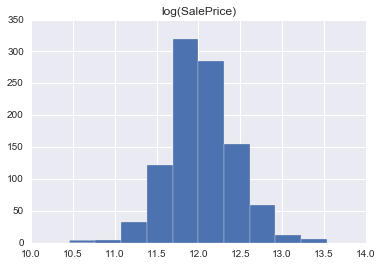

In [45]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

In [45]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               

In [46]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 3373)
(230, 3373)
(497, 3373)
(229, 3373)


In [49]:
import re
import time

def gen_submission(preds, test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

In [48]:
import re
import time

def gen_submission_glm(model, test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


In [49]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

In [50]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                       model_ids  \
0    [0.25]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_1   
1     [0.5]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_2   
2    [0.99]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_3   
3    [0.01]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_0   

    residual_deviance  
0  3.4056149704726546  
1  3.4432799816367816  
2  3.4997037522117393  
3  3.7551576194833487  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013012961718910504
RMSE: 0.11407436924616547
MAE: 0.0804187668027057
RMSLE: 0.00892713691702441
R^2: 0.9169172448836034
Mean Residual Deviance: 0.013012961718910504
Null degrees

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-28 18:19:13,0.000 sec,0,.12E1,5,0.1494544,0.1443685
,2017-06-28 18:19:13,0.064 sec,0,.12E1,9,0.1408230,0.1363925
,2017-06-28 18:19:13,0.147 sec,0,.11E1,13,0.1325019,0.1287985
,2017-06-28 18:19:13,0.201 sec,0,.11E1,14,0.1245454,0.1215788
,2017-06-28 18:19:14,0.255 sec,0,.1E1,18,0.1170253,0.1147682
---,---,---,---,---,---,---,---
,2017-06-28 18:19:32,18.379 sec,0,.16E-1,140,0.0109210,0.0171281
,2017-06-28 18:19:32,18.715 sec,0,.15E-1,141,0.0108272,0.0173807
,2017-06-28 18:19:32,19.062 sec,0,.14E-1,142,0.0107194,0.0176685
,2017-06-28 18:19:33,19.400 sec,0,.14E-1,148,0.0106092,0.0180386



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0584
12.2061,12.1591
11.6784,11.7536
11.914,11.7733
12.6758,12.4255
12.861,12.7446
12.1035,11.9404
11.2898,11.3687
11.7714,11.6492
11.5843,11.5342



glm prediction progress: |████████████████████████████████████████████████| 100%


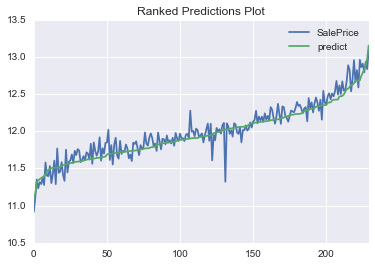

In [51]:
glm0_0 = glm_grid(encoded_combined_nums, 'SalePrice',  half_train, half_valid)
gen_submission_glm(glm0_0,test) # Valid RMSE: 0.1325 #0.1216

In [56]:
#glm0_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission_glm(glm0_1,test) # Valid RMSE: 0.11931 0.116

glm prediction progress: |████████████████████████████████████████████████| 100%


In [57]:
pred_blender('/Users/zhaorc/Desktop/ML/files', 
             ['Wed_Jun_28_18_20_10_2017.csv',
              'Wed_Jun_28_18_24_29_2017.csv'])
# 0.13337 on public leaderboard, better than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  111616.590094  102381.940726  106999.265410
1  1462  142175.020593  142154.134369  142164.577481
2  1463  173016.519084  167166.252038  170091.385561
3  1464  190380.120019  183069.989015  186725.054517
4  1465  211946.803098  202118.377125  207032.590112


In [58]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
#ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.16494 on public leaderboard

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1498680313620_18


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.005951338975738817
RMSE: 0.07714492190506655
MAE: 0.04475082145942436
RMSLE: 0.005984590186400224
Mean Residual Deviance: 0.005951338975738817

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.01726121707486444
RMSE: 0.13138195110008238
MAE: 0.09628202193183318
RMSLE: 0.010218852608867847
Mean Residual Deviance: 0.01726121707486444

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.019265849631246473
RMSE: 0.13880147560903838
MAE: 0.09351138897113628
RMSLE: 0.010747689924979183
Mean Residual Deviance: 0.019265849631246473
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0935678,0.0012082,0.0934574,0.0915325,0.0957134
mean_residual_deviance,0.0192219,0.0015446,0.0204971,0.0210210,0.0161476
mse,0.0192219,0.0015446,0.0204971,0.0210210,0.0161476
r2,0.8752149,0.0031889,0.8701856,0.8811260,0.8743331
residual_deviance,0.0192219,0.0015446,0.0204971,0.0210210,0.0161476
rmse,0.1384092,0.0056922,0.1431681,0.1449861,0.1270733
rmsle,0.0107126,0.0004767,0.0110911,0.0112812,0.0097655


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-28 18:30:02,40.669 sec,0.0,11.5392208,11.5324996,133.1536163,11.5129466,11.5056257,132.5479390
,2017-06-28 18:30:02,40.714 sec,1.0,11.4819725,11.4752177,131.8356917,11.4557013,11.4483439,131.2330931
,2017-06-28 18:30:02,40.719 sec,2.0,11.4253924,11.4186042,130.5395908,11.3991243,11.3917303,129.9400351
,2017-06-28 18:30:02,40.728 sec,3.0,11.3685161,11.3616939,129.2431577,11.3422512,11.3348201,128.6466622
,2017-06-28 18:30:02,40.733 sec,4.0,11.3123396,11.3054835,127.9690267,11.2860778,11.2786097,127.3755523
---,---,---,---,---,---,---,---,---,---
,2017-06-28 18:30:10,48.703 sec,2821.0,0.1085613,0.0694647,0.0117856,0.1288138,0.0924454,0.0165930
,2017-06-28 18:30:14,52.705 sec,4589.0,0.0971335,0.0600609,0.0094349,0.1282752,0.0937001,0.0164545
,2017-06-28 18:30:18,56.706 sec,6605.0,0.0880463,0.0529085,0.0077522,0.1295897,0.0951104,0.0167935
,2017-06-28 18:30:24,1 min 2.377 sec,9822.0,0.0776082,0.0451581,0.0060230,0.1316268,0.0964537,0.0173256



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Id,3441.0,1.0,0.0583339
LotArea,3274.0,0.9514676,0.0555028
GrLivArea,3137.0,0.9116536,0.0531803
BsmtUnfSF,3107.0,0.9029352,0.0526717
1stFlrSF,2693.0,0.7826213,0.0456534
---,---,---,---
GarageQual_Tencode,34.0,0.0098808,0.0005764
LandContour_Tencode,18.0,0.0052310,0.0003051
Alley_Tencode,8.0,0.0023249,0.0001356
BsmtCond_Tencode,7.0,0.0020343,0.0001187



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [59]:
gen_submission(h2o_xgb_preds1_test)

In [46]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
#ranked_preds_plot('SalePrice', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test,tesdt) # 0.14574 public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1498689887404_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.017465047624399446
RMSE: 0.13215539196112827
MAE: 0.08985047747144462
RMSLE: 0.010274034427532316
Mean Residual Deviance: 0.017465047624399446

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.016856437588690557
RMSE: 0.12983234415464645
MAE: 0.09266319949920339
RMSLE: 0.010043923523736568
Mean Residual Deviance: 0.016856437588690557

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.01857373183889105
RMSE: 0.13628547919309325
MAE: 0.08988988575395503
RMSLE: 0.01060257046671778
Mean Residual Deviance: 0.01857373183889105
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0898669,0.0003805,0.0892916,0.0905859,0.0897232
mean_residual_deviance,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
mse,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
r2,0.879554,0.0049428,0.8708518,0.8879668,0.8798433
residual_deviance,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
rmse,0.1359363,0.0058699,0.1428003,0.1407526,0.1242561
rmsle,0.0105669,0.0005157,0.0111116,0.0110530,0.0095361


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-28 18:54:03,4 min 4.625 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-28 18:54:03,4 min 5.087 sec,1.0,0.2053192,0.1442051,0.0421560,0.1914737,0.1385821,0.0366622
,2017-06-28 18:54:04,4 min 5.588 sec,2.0,0.2021184,0.1451268,0.0408518,0.1678469,0.1206358,0.0281726
,2017-06-28 18:54:04,4 min 6.077 sec,3.0,0.2059234,0.1444103,0.0424045,0.1531739,0.1111464,0.0234622
,2017-06-28 18:54:05,4 min 6.571 sec,4.0,0.1917852,0.1371583,0.0367816,0.1456185,0.1055259,0.0212048
---,---,---,---,---,---,---,---,---,---
,2017-06-28 18:55:33,5 min 35.108 sec,168.0,0.1324222,0.0899862,0.0175356,0.1298885,0.0927521,0.0168710
,2017-06-28 18:55:34,5 min 35.663 sec,169.0,0.1322458,0.0898968,0.0174889,0.1299202,0.0927988,0.0168793
,2017-06-28 18:55:34,5 min 36.217 sec,170.0,0.1322448,0.0898847,0.0174887,0.1297955,0.0927027,0.0168469
,2017-06-28 18:55:35,5 min 36.696 sec,171.0,0.1322186,0.0898393,0.0174818,0.1298279,0.0926693,0.0168553



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt_Tencode|GrLivArea,2081.1440430,1.0,0.0877169
Neighborhood_Tencode|OverallQual_Tencode,1428.1538086,0.6862350,0.0601944
BsmtQual_Tencode|GrLivArea,1332.3436279,0.6401977,0.0561561
Neighborhood_Tencode|GrLivArea,1069.4122314,0.5138579,0.0450740
LotShape_Tencode|OverallQual_Tencode,898.1904907,0.4315850,0.0378573
---,---,---,---
Street_Tencode|BsmtHalfBath,0.0,0.0,0.0
KitchenAbvGr|GarageCond_Tencode,0.0,0.0,0.0
BsmtHalfBath|WoodDeckSF,0.0,0.0,0.0
BsmtHalfBath|OverallQual_Tencode,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


NameError: name 'ranked_preds_plot' is not defined

In [ ]:
# initialize extra trees model
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.14855 public leaderboard

drf Model Build progress: |█

In [65]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.15062 public leaderboard

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a359123b8bb75754a89265b3b884ec6> was cancelled by the user.